# Analyzing KDF Robustness to Label Noise

This tutorial seeks to expand on `bayeserrorestimate_gaussianparity.ipynb` by exploring a property of the Kerenel Density Forest (KDF). Here, the goal is to explore robustness to contamination in the Gaussian XOR distribution compared to the Random Forest (RF) algorithm. 

Recall from `bayeserrorestimate_gaussianparity.ipynb` that the **estimated Bayes Error is 0.267.**

In [1]:
# Created by: Jacob Desman
# Date: 2021-11-22
# Contact at: jake.m.desman@gmail.com

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from kdg.utils import generate_gaussian_parity
from kdg import kdf
from sklearn.ensemble import RandomForestClassifier as rf

## Distributions of Interest
As an example, we show the Guassian parity problem of interest below. The left figure shows the original distribution while the right figure illustrates 20% contamination in the labels.

Text(0.5, 1.0, '20% Flipped Labels')

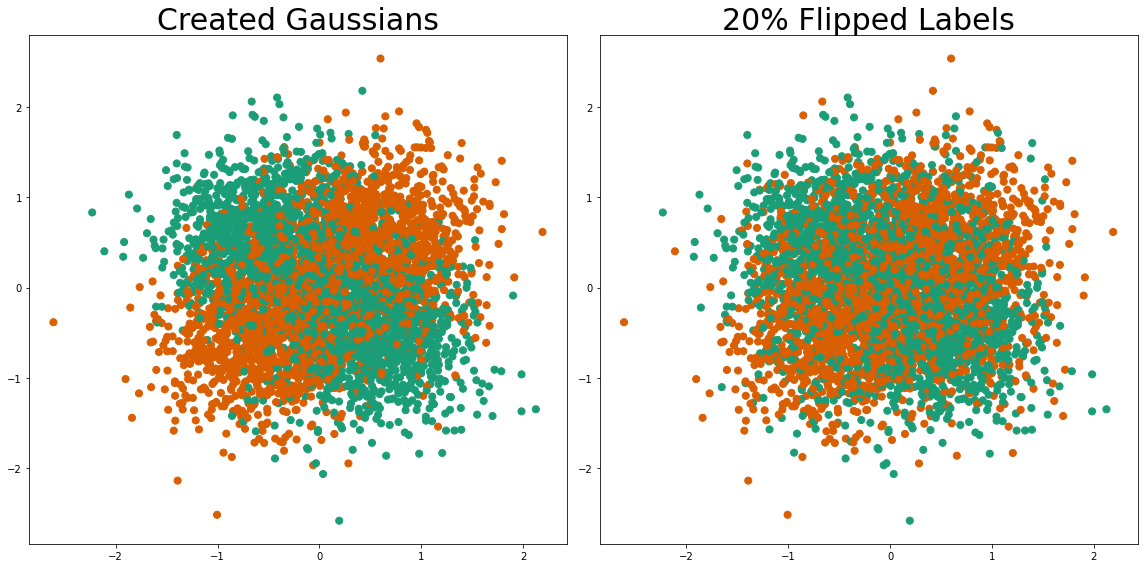

In [3]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

def plot_gaussians(Values, Classes, ax=None):
    X = Values
    y = Classes
    colors = sns.color_palette("Dark2", n_colors=2)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=get_colors(colors, y), s=50)
    ax.set_title("Created Gaussians", fontsize=30)
    plt.tight_layout()

# Show the sample blobs / Gaussians
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
n_samples = 5000

# Generate original distribution
X, y = generate_gaussian_parity(n_samples, cluster_std=0.5)
plot_gaussians(X, y, ax=ax[0])
plt.gca().set_title('Uncontaminated Labels', fontsize=30)

# Randomly flip labels
p = 0.20
n_noise = np.int32(np.round(len(X) * p))
noise_indices = random.sample(range(len(X)), n_noise)
y[noise_indices] = 1 - y[noise_indices]
plot_gaussians(X, y, ax=ax[1])
plt.gca().set_title('20% Flipped Labels', fontsize=30)

## Experiment: Accuracy in Contaminated Environment
This will compare the error rate of the Kernel Density Forest algorithm to the Random Forest algorithm at different label contamination levels: 0%, 10%, 20%, 30%, and 40%. Multiple trials will be conducted at each contamination level.

In [4]:
def label_noise_trial(n_samples, p=0.10, n_estimators=500):
    """
    Runs a single trial of the label noise experiment at
    a given contamination level.
    
    Parameters
    ---
    n_samples : int
        The number of training samples to be generated
    p : float
        The proportion of flipped training labels
    n_estimators : int
        Number of trees in the KDF and RF forests
        
    Returns
    ---
    error_kdf : float
        The estimated from KDF on the test distribution
    error_rf : float
        The estimated error from RF on the test distribution
    """
    X, y = generate_gaussian_parity(n_samples, cluster_std=0.5)
    X_test, y_test = generate_gaussian_parity(1000, cluster_std=0.5)

    # Generate noise and flip labels
    n_noise = np.int32(np.round(len(X) * p))
    noise_indices = random.sample(range(len(X)), n_noise)
    y[noise_indices] = 1 - y[noise_indices]

    model_kdf = kdf(kwargs={"n_estimators": n_estimators})
    model_kdf.fit(X, y)
    error_kdf = 1 - np.mean(model_kdf.predict(X_test) == y_test)

    model_rf = rf(n_estimators=n_estimators)
    model_rf.fit(X, y)
    error_rf = 1 - np.mean(model_rf.predict(X_test) == y_test)
    return error_kdf, error_rf

Doing proportion 0.0
KDF error = 0.295, RF error = 0.326
KDF error = 0.280, RF error = 0.310
KDF error = 0.260, RF error = 0.293
KDF error = 0.283, RF error = 0.303
KDF error = 0.276, RF error = 0.296
KDF error = 0.266, RF error = 0.280
KDF error = 0.272, RF error = 0.299
KDF error = 0.267, RF error = 0.284
KDF error = 0.275, RF error = 0.312
KDF error = 0.255, RF error = 0.284
Doing proportion 0.1
KDF error = 0.254, RF error = 0.308
KDF error = 0.269, RF error = 0.318
KDF error = 0.283, RF error = 0.328
KDF error = 0.297, RF error = 0.334
KDF error = 0.279, RF error = 0.324
KDF error = 0.282, RF error = 0.314
KDF error = 0.290, RF error = 0.345
KDF error = 0.295, RF error = 0.349
KDF error = 0.287, RF error = 0.327
KDF error = 0.281, RF error = 0.329
Doing proportion 0.2
KDF error = 0.275, RF error = 0.353
KDF error = 0.304, RF error = 0.340
KDF error = 0.297, RF error = 0.363
KDF error = 0.276, RF error = 0.344
KDF error = 0.310, RF error = 0.357
KDF error = 0.275, RF error = 0.342
K

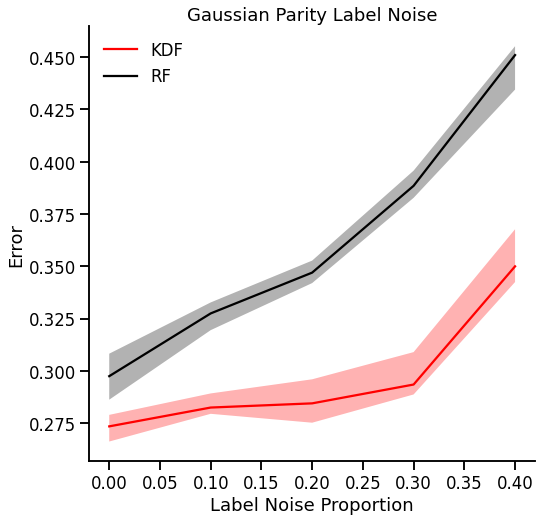

In [5]:
df = pd.DataFrame()
reps = 10
n_estimators = 500
n_samples = 5000

err_kdf = []
err_rf = []
proportions = [0.0, 0.1, 0.2, 0.3, 0.4]
proportion_list = []
reps_list = []

for p in proportions:
    print("Doing proportion {}".format(p))
    for ii in range(reps):
        err_kdf_i, err_rf_i = label_noise_trial(
            n_samples=n_samples, p=p, n_estimators=n_estimators
        )
        err_kdf.append(err_kdf_i)
        err_rf.append(err_rf_i)
        reps_list.append(ii)
        proportion_list.append(p)
        print("KDF error = {:.3f}, RF error = {:.3f}".format(err_kdf_i, err_rf_i))

# Construct DataFrame
df["reps"] = reps_list
df["proportion"] = proportion_list
df["error_kdf"] = err_kdf
df["error_rf"] = err_rf

err_kdf_med = []
err_kdf_25_quantile = []
err_kdf_75_quantile = []
err_rf_med = []
err_rf_25_quantile = []
err_rf_75_quantile = []

for p in proportions:
    curr_kdf = df["error_kdf"][df["proportion"] == p]
    curr_rf = df["error_rf"][df["proportion"] == p]

    err_kdf_med.append(np.median(curr_kdf))
    err_kdf_25_quantile.append(np.quantile(curr_kdf, [0.25])[0])
    err_kdf_75_quantile.append(np.quantile(curr_kdf, [0.75])[0])

    err_rf_med.append(np.median(curr_rf))
    err_rf_25_quantile.append(np.quantile(curr_rf, [0.25])[0])
    err_rf_75_quantile.append(np.quantile(curr_rf, [0.75])[0])

# Plotting
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(proportions, err_kdf_med, c="r", label="KDF")
ax.fill_between(
    proportions, err_kdf_25_quantile, err_kdf_75_quantile, facecolor="r", alpha=0.3
)
ax.plot(proportions, err_rf_med, c="k", label="RF")
ax.fill_between(
    proportions, err_rf_25_quantile, err_rf_75_quantile, facecolor="k", alpha=0.3
)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_xlabel("Label Noise Proportion")
ax.set_ylabel("Error")
plt.title("Gaussian Parity Label Noise")
ax.legend(frameon=False)
plt.show()